<a href="https://colab.research.google.com/github/FedericoSabbadini/RetiNeuraliGenerative/blob/main/lezione/CycleGAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **CycleGAN**

In this exercise, we will see the fundamentals block that constitute a Generative Adversarial Network (GAN), in particular with a focus over the CycleGAN introduced by [Zhu et al. (2017)](https://arxiv.org/pdf/1703.10593).
First, we'll introduce the Dataset, then the Architecture, and finally we'll test the Generators.


---

### **The Dataset**

The pictures for this task are taken from this [CycleGAN Kaggle Repository](https://www.kaggle.com/datasets/suyashdamle/cyclegan). In this repo are contained different sets of pictures if you want to experiment some more.


In [1]:
import gdown
gdown.download(f"https://drive.google.com/uc?id=1v9b2kKLkrWulvbd1wSTA5QCbAkmbtQyr", "data.gz", quiet=False)

!tar -xzf data.gz

Downloading...
From (original): https://drive.google.com/uc?id=1v9b2kKLkrWulvbd1wSTA5QCbAkmbtQyr
From (redirected): https://drive.google.com/uc?id=1v9b2kKLkrWulvbd1wSTA5QCbAkmbtQyr&confirm=t&uuid=35a50d0d-5404-442c-9021-ff1f516d8816
To: /content/data.gz
100%|██████████| 301M/301M [00:06<00:00, 48.3MB/s]


In [2]:
import os
import torch
import random
import numpy as np
import torch.nn as nn

SEED = 9652

def set_seed(seed):
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    np.random.seed(seed)
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)

set_seed(SEED)

Let's explore the dataset

In [3]:
DATA_DIR = "GAN/vangogh2photo"

# number of photos in each dirs

for d in ["train/vangogh", "train/photo", "val/vangogh", "val/photo"]:
    print(f"{len(os.listdir(os.path.join(DATA_DIR, d)))} images for {d}")

400 images for train/vangogh
6287 images for train/photo
400 images for val/vangogh
751 images for val/photo


Image dimension: 256 x 256 x RGB


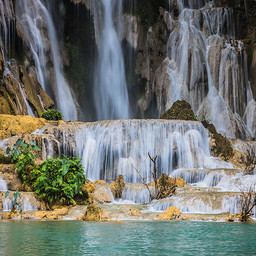

In [4]:
from PIL import Image


photo = Image.open(os.path.join(DATA_DIR, "train/photo/00001.jpg"))
width, height = photo.size

print(f"Image dimension: {width} x {height} x {photo.mode}")
photo

Image dimension: 256 x 256


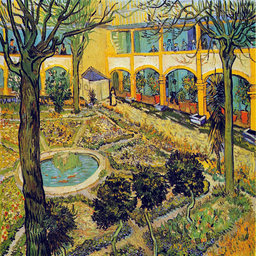

In [5]:
vangogh = Image.open(os.path.join(DATA_DIR, "train/vangogh/00001.jpg"))
width, height = vangogh.size

print(f"Image dimension: {width} x {height}")
vangogh

In [6]:
from torch.utils.data import Dataset, DataLoader


class VanGogh2Photo(Dataset):

    def __init__(self, root_photo, root_vangogh, transform):
        super(VanGogh2Photo, self).__init__()

        self.root_photo = root_photo
        self.root_vangogh = root_vangogh

        self.photo_images = os.listdir(root_photo)
        self.vangogh_images = os.listdir(root_vangogh)

        self.photo_len = len(self.photo_images)
        self.vangogh_len = len(self.vangogh_images)

        self.transform = transform

    def __len__(self):
        return max(self.photo_len, self.vangogh_len)                                # 751 --> 0 -> 750


    def __getitem__(self, index):

        photo_img = self.photo_images[index % self.photo_len]                       # 750 images
        vangogh_img = self.vangogh_images[index % self.vangogh_len]                 # 400 images

        photo_img = np.array(Image.open(os.path.join(self.root_photo, photo_img)).convert("RGB"))
        vangogh_img = np.array(Image.open(os.path.join(self.root_vangogh, vangogh_img)).convert("RGB"))

        return self.transform(photo_img), self.transform(vangogh_img)


In [7]:
import torchvision.transforms as transforms


NORMALIZATION = (0.5, 0.5, 0.5), (0.5, 0.5, 0.5)
NUM_WORKERS = 2
BATCH_SIZE = 1

def denorm(image):
    return image * NORMALIZATION[1][0] + NORMALIZATION[0][0]


transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(*NORMALIZATION)
])

train_dataset = VanGogh2Photo(
    os.path.join(DATA_DIR, "train/photo"),
    os.path.join(DATA_DIR, "train/vangogh"),
    transform
)

val_dataset = VanGogh2Photo(
    os.path.join(DATA_DIR, "val/photo"),
    os.path.join(DATA_DIR, "val/vangogh"),
    transform,
)

train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, num_workers=NUM_WORKERS, shuffle=True, pin_memory=True)
val_dataloader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, pin_memory=True)

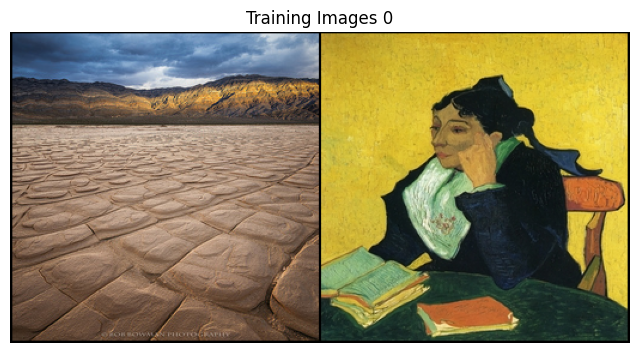

In [8]:
import torchvision.utils as vutils
import matplotlib.pyplot as plt


for i, (photo, vangogh) in enumerate(val_dataloader):

    plt.figure(figsize=(8, 8))
    plt.axis("off")
    plt.title(f"Training Images {i}")
    plt.imshow(np.transpose(vutils.make_grid([denorm(photo[0]), denorm(vangogh[0])], padding=2).cpu(), (1, 2, 0)))

    break


---

### **The CycleGAN Architecture**

Here, we'll see the main components of the CycleGAN Architecture: the generators and the discriminators.


**Generator Architecture**


<br>
<img alt width="700" height="439" src="https://miro.medium.com/v2/resize:fit:1400/1*PVBSmRcCz9xfw-fCNi_q5g.png">

In [9]:
class EncoderBlock(nn.Module):

    def __init__(self, in_channels, out_channels, kernel_size, stride, padding):
        super(EncoderBlock, self).__init__()

        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding, padding_mode="reflect")
        self.norm = nn.InstanceNorm2d(out_channels)
        self.relu = nn.ReLU()

    def forward(self, x):
        return self.relu(self.norm(self.conv(x)))


In [10]:
class ResidualBlock(nn.Module):

    def __init__(self, channels, kernel_size, stride, padding):
        super(ResidualBlock, self).__init__()

        self.conv1 = nn.Conv2d(channels, channels,  kernel_size, stride, padding, padding_mode="reflect")
        self.conv2 = nn.Conv2d(channels, channels,  kernel_size, stride, padding, padding_mode="reflect")

        self.norm = nn.InstanceNorm2d(channels)
        self.relu = nn.ReLU()


    def forward(self, x):
        out = self.relu(self.norm(self.conv1(x)))
        out = self.norm(self.conv2(out))
        return x + out # skip connection


In [11]:
class DecoderBlock(nn.Module):

    def __init__(self, in_channels, out_channels, kernel_size, stride, padding, output_padding):
        super(DecoderBlock, self).__init__()

        self.tconv = nn.ConvTranspose2d(in_channels, out_channels, kernel_size, stride, padding, output_padding) # upsampling
        self.norm = nn.InstanceNorm2d(out_channels)
        self.relu = nn.ReLU()

    def forward(self, x):
        return self.relu(self.norm(self.tconv(x)))

In [12]:
class Generator(nn.Module):

    def __init__(self, img_channels=3, num_features=64, num_residuals=9):
        super(Generator, self).__init__()

        self.initial_layer = nn.Sequential(
            nn.Conv2d(
                img_channels,
                num_features,
                kernel_size=7,
                stride=1,
                padding=3,
                padding_mode="reflect"
            ),
            nn.ReLU(inplace=True)
        )

        self.enc1 = EncoderBlock(
            num_features * 1,
            num_features * 2,
            kernel_size=3,
            stride=2,
            padding=1,
        )


        self.enc2 = EncoderBlock(
            num_features * 2,
            num_features * 4,
            kernel_size=3,
            stride=2,
            padding=1,
        )




        self.residual = nn.ModuleList(
            [
                ResidualBlock(
                    num_features * 4,
                    kernel_size=3,
                    stride=1,
                    padding=1
                )
            ] * num_residuals
        )



        self.dec1 = DecoderBlock(
            num_features * 4,
            num_features * 2,
            kernel_size=3,
            stride=2,
            padding=1,
            output_padding=1
        )


        self.dec2 = DecoderBlock(
            num_features * 2,
            num_features * 1,
            kernel_size=3,
            stride=2,
            padding=1,
            output_padding=1
        )

        self.final_layer = nn.Sequential(
            nn.Conv2d(
                num_features,
                img_channels,
                kernel_size=7,
                stride=1,
                padding=3,
                padding_mode="reflect"
            ),
            nn.Tanh()
        )


    def forward(self, x):

        x = self.enc2(self.enc1(self.initial_layer(x)))

        for layer in self.residual:
            x = layer(x)

        x = self.final_layer(self.dec2(self.dec1(x)))

        return x


**Discriminator Architecture**

<br>
<img alt width="700" height="549" src="https://miro.medium.com/v2/resize:fit:1400/1*46CddTc5JwkFW_pQb4nGZQ.png">

In [13]:
class DiscriminatorBlock(nn.Module):

    def __init__(self, in_channels, out_channels, kernel_size, stride, padding, bias):
        super(DiscriminatorBlock, self).__init__()

        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding, bias=bias, padding_mode="reflect")
        self.norm = nn.InstanceNorm2d(out_channels)
        self.relu = nn.LeakyReLU(0.2)

    def forward(self, x):
        return self.relu(self.norm(self.conv(x)))


In [14]:
class Discriminator(nn.Module):

    def __init__(self, img_channels=3, num_features=64):
        super(Discriminator, self).__init__()

        self.initial_layer = nn.Sequential(
            nn.Conv2d(
                img_channels,
                num_features,
                kernel_size=4,
                stride=2,
                padding=1,
                padding_mode="reflect"
            ),
            nn.LeakyReLU(0.2) #previene i dead neurons
        )

        # 4 layer di convoluzione con stride 2. Output una mappa di prob
        self.disc1 = DiscriminatorBlock(
            num_features * 1,
            num_features * 2,
            kernel_size=4,
            stride=2,
            padding=1,
            bias=True
        )

        self.disc2 = DiscriminatorBlock(
            num_features * 2,
            num_features * 4,
            kernel_size=4,
            stride=2,
            padding=1,
            bias=True
        )

        self.disc3 = DiscriminatorBlock(
            num_features * 4,
            num_features * 8,
            kernel_size=4,
            stride=2,
            padding=1,
            bias=True
        )

        self.final_layer = nn.Sequential(
            nn.Conv2d(
                num_features * 8,
                1,
                kernel_size=4,
                stride=1,
                padding=1,
                padding_mode="reflect"
            ),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.initial_layer(x)
        x = self.disc3(self.disc2(self.disc1(x)))
        return self.final_layer(x)

**GAN Training Procedure**

Finally, let's dive into the training algorith, the real core of the GAN architecture

In [15]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"using device: {device}")


# architecture hyper-parameters

NUM_CHANNELS = 3
GEN_FEATURES = 64
DISC_FEATURES = 64
GEN_RESIDUALS = 9

# training hyper-parameters

LR = 1e-5
LAMBDA_CYCLE = 10
NUM_EPOCHS = 50

SAVE_DIR = "models/gan"
os.makedirs(SAVE_DIR, exist_ok=True)

using device: cuda


In [18]:
from torch.optim import Adam
from torch.amp import GradScaler, autocast
from tqdm import tqdm
from torchvision.utils import save_image


class CycleGAN(nn.Module):

    def __init__(self, color_dim, gens_features, discs_features, gens_rediduals, lr, model_name, device):
        super(CycleGAN, self).__init__()

        self.model_name = model_name
        self.device = device
        self.lr = lr


        self.photo_generator = Generator(color_dim, gens_features, gens_rediduals)
        self.vangogh_generator = Generator(color_dim, gens_features, gens_rediduals)

        self.photo_discriminator = Discriminator(color_dim, discs_features)
        self.vangogh_discriminator = Discriminator(color_dim, discs_features)

        self.optimizerG = Adam(
            list(self.photo_generator.parameters()) + list(self.vangogh_generator.parameters()),
            lr=lr,
            betas=(0.5, 0.999)
        )
        self.optimizerD = Adam(
            list(self.photo_discriminator.parameters()) + list(self.vangogh_discriminator.parameters()),
            lr=lr,
            betas=(0.5, 0.999)
        )

        self.scalerG = GradScaler()
        self.scalerD = GradScaler()

        self.l1_loss = nn.L1Loss()
        self.mse_loss = nn.MSELoss()


    def forward(self):
        raise NotImplementedError("Forward method not implemented.")


    def train_architecture(self, num_epochs, train_dataloader):

        for epoch in tqdm(range(num_epochs)):
            self.train()

            for idx, (photo, vangogh) in enumerate(train_dataloader):

                photo = photo.to(self.device)
                vangogh = vangogh.to(self.device)

                # Train discriminators.
                with autocast('cuda'):

                    fake_vangogh = self.vangogh_generator(photo)

                    D_V_fake = self.vangogh_discriminator(fake_vangogh.detach()) # evita che il gradiente torni al generatore!
                    D_V_real = self.vangogh_discriminator(vangogh)

                    D_V_real_loss = self.mse_loss(D_V_real, torch.ones_like(D_V_real))
                    D_V_fake_loss = self.mse_loss(D_V_fake, torch.zeros_like(D_V_fake))
                    D_V_loss = D_V_real_loss + D_V_fake_loss


                    fake_photo = self.photo_generator(vangogh)

                    D_P_real = self.photo_discriminator(photo)
                    D_P_fake = self.photo_discriminator(fake_photo.detach())

                    D_P_real_loss = self.mse_loss(D_P_real, torch.ones_like(D_P_real))
                    D_P_fake_loss = self.mse_loss(D_P_fake, torch.zeros_like(D_P_fake))
                    D_P_loss = D_P_real_loss + D_P_fake_loss

                    D_loss = (D_V_loss + D_P_loss) / 2

                self.optimizerD.zero_grad()
                self.scalerD.scale(D_loss).backward()
                self.scalerD.step(self.optimizerD)
                self.scalerD.update()

                # Train generators.
                with autocast('cuda'):

                    D_V_fake = self.vangogh_discriminator(fake_vangogh)
                    D_P_fake = self.photo_discriminator(fake_photo)

                    loss_G_V = self.mse_loss(D_V_fake, torch.ones_like(D_V_fake))
                    loss_G_P = self.mse_loss(D_P_fake, torch.ones_like(D_P_fake))


                    # Cycle Loss
                    cycle_photo = self.photo_generator(fake_vangogh)
                    cycle_vangogh = self.vangogh_generator(fake_photo)

                    cycle_photo_loss = self.l1_loss(cycle_photo, photo)
                    cycle_vangogh_loss = self.l1_loss(cycle_vangogh, vangogh)

                    cycle_loss = cycle_photo_loss + cycle_vangogh_loss

                    G_loss = loss_G_V + loss_G_P + LAMBDA_CYCLE * (cycle_loss)


                self.optimizerG.zero_grad()
                self.scalerG.scale(G_loss).backward()
                self.scalerG.step(self.optimizerG)
                self.scalerG.update()

                if epoch % 5 == 0 and idx % 800 == 0:
                    if not os.path.exists(f"outputs/epoch_{epoch}"):
                        os.makedirs(f"outputs/epoch_{epoch}")

                    save_image(denorm(fake_vangogh), f"outputs/epoch_{epoch}/vangogh_{idx}.png")
                    save_image(denorm(fake_photo), f"outputs/epoch_{epoch}/photo_{idx}.png")

            tqdm.write(f" Epoch {epoch}: D Loss {round(D_loss.item(), 4)} - G Loss: {round(G_loss.item(), 4)}")

            if epoch % 5 == 0 or epoch == num_epochs - 1:
                torch.save(self.state_dict(), os.path.join(SAVE_DIR, self.model_name + f"_{epoch}.pth"))


    def photo2vangogh(self, photo):
        self.eval()
        with torch.no_grad():
            photo = photo.to(self.device)
            return self.vangogh_generator(photo).detach().cpu()


    def vangogh2photo(self, vangogh):
        self.eval()
        with torch.no_grad():
            vangogh = vangogh.to(self.device)
            return self.photo_generator(vangogh).detach().cpu()


In [ ]:
model = CycleGAN(NUM_CHANNELS, GEN_FEATURES, DISC_FEATURES, GEN_RESIDUALS, LR, "vangogh2photo", device).to(device)
model.train_architecture(NUM_EPOCHS, train_dataloader)

  0%|          | 0/50 [00:00<?, ?it/s]

In [ ]:
import gdown
gdown.download(f"https://drive.google.com/uc?id=16W8P5kxm1R_1TgAOzpMGGbfTdPfdVkox", "GAN_Training.gz", quiet=False)

!tar -xzf GAN_Training.gz

In [ ]:
import matplotlib.pyplot as plt

D_losses = np.load("models/d_losses.npy")
G_losses = np.load("models/g_losses.npy")


plt.figure(figsize=(10, 5))
plt.plot(D_losses, label="Discriminator loss")
plt.plot(G_losses, label="Generation loss")
plt.legend()
plt.grid()
plt.show()


---

### **Testing the Generators**



In [ ]:
RANDOM_INDXS = random.sample(range(len(val_dataset)), 8)

def visualize_fakes(model: CycleGAN, val_dataset):

    img_list = []
    for idx in RANDOM_INDXS:

            photo, vangogh = val_dataset[idx]

            fake_vangogh = model.photo2vangogh(photo)
            fake_photo = model.vangogh2photo(vangogh)

            img_list.extend([denorm(photo),
                            denorm(fake_vangogh),
                            denorm(vangogh),
                            denorm(fake_photo)])

    plt.figure(figsize=(20, 20))
    plt.axis("off")
    plt.imshow(np.transpose(vutils.make_grid(img_list, nrow=4, padding=2).cpu(), (1, 2, 0)))


In [ ]:
model.load_state_dict(torch.load("models/gan/vangogh2photo_5.pth", weights_only=False))
visualize_fakes(model, val_dataset)

In [ ]:
model.load_state_dict(torch.load("models/gan/vangogh2photo_45.pth", weights_only=False))
visualize_fakes(model, val_dataset)

In [ ]:
fake_vangoghs = []
fake_photos = []


saved_models = os.listdir(SAVE_DIR)
ordered_models = sorted(saved_models, key=lambda x: int(x.split("_")[-1].split(".")[0]))

for cgan in ordered_models:
    model.load_state_dict(torch.load(os.path.join(SAVE_DIR, cgan), weights_only=False))

    fake_vangogh_ep = []
    fake_photos_ep = []
    for idx in RANDOM_INDXS:

        photo, vangogh = val_dataset[idx]

        fake_vangogh = model.photo2vangogh(photo)
        fake_photo = model.vangogh2photo(vangogh)

        fake_vangogh_ep.append(denorm(fake_vangogh.detach().cpu().numpy()))
        fake_photos_ep.append(denorm(fake_photo.detach().cpu().numpy()))

    fake_vangoghs.append(fake_vangogh_ep)
    fake_photos.append(fake_photos_ep)


fake_vangoghs = np.stack(fake_vangoghs)
fake_photos = np.stack(fake_photos)

fake_vangoghs.shape, fake_photos.shape

In [ ]:
real_photos = []
real_vangoghs = []

for idx in RANDOM_INDXS:
    photo, vangogh = val_dataset[idx]
    real_photos.append(denorm(photo.detach().cpu().numpy()))
    real_vangoghs.append(denorm(vangogh.detach().cpu().numpy()))


real_photos = np.stack(real_photos)
real_vangoghs = np.stack(real_vangoghs)

real_photos.shape, real_vangoghs.shape

In [ ]:
from matplotlib.animation import FuncAnimation
from IPython.display import HTML

# epochs, num_Images, num_channels, height, width
# (10, 8, 3, 256, 256)

def plot_sample(fake_images, real_images, nrows=2):

    ncols = fake_images.shape[1] // nrows
    fake_images = np.moveaxis(fake_images, 2, 4)                               # change to Numpy image format (h, w, channels) vs (channels, h, w)

    # create gif of images evolving over time, based on images
    fig, axs = plt.subplots(nrows=nrows, ncols=ncols, sharex=True, sharey=True, figsize=(8, 4))

    def animate_diff(i, store):
        plots = []
        for row in range(nrows):
            for col in range(ncols):
                axs[row, col].clear()
                axs[row, col].set_xticks([])
                axs[row, col].set_yticks([])
                plots.append(axs[row, col].imshow(store[i,(row*ncols)+col]))
        return plots

    ani = FuncAnimation(fig, animate_diff, fargs=[fake_images],  interval=200, blit=False, repeat=True, frames=fake_images.shape[0])
    plt.close()


    _, axs2 = plt.subplots(nrows=nrows, ncols=ncols, sharex=True, sharey=True, figsize=(8, 4))

    real_images = np.moveaxis(real_images, 1, 3)

    for row in range(nrows):
        for col in range(ncols):
            axs2[row, col].clear()
            axs2[row, col].set_xticks([])
            axs2[row, col].set_yticks([])
            axs2[row, col].imshow(real_images[(row*ncols)+col])


    return ani

In [ ]:
ani = plot_sample(fake_vangoghs, real_photos, nrows=2)
HTML(ani.to_jshtml())

In [ ]:
ani = plot_sample(fake_photos, real_vangoghs, nrows=2)
HTML(ani.to_jshtml())